In [1]:
from mlflow.tracking import MlflowClient
from os.path import join
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

mlflow_path = "/home/davina/Private/repos/CRRT/mlruns"
data_path = "/home/davina/Private/crrt-data"
client = MlflowClient(mlflow_path)

In [2]:
from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    accuracy_score,
    f1_score,
    average_precision_score,
    recall_score,
    precision_score,
    confusion_matrix,
)

METRIC_MAP = {
    "auroc": lambda gt, pred_probs, decision_thresh: roc_auc_score(gt, pred_probs),
    "ap": lambda gt, pred_probs, decision_thresh: average_precision_score(
        gt, pred_probs
    ),
    "brier": lambda gt, pred_probs, decision_thresh: brier_score_loss(gt, pred_probs),
    "accuracy": lambda gt, pred_probs, decision_thresh: accuracy_score(
        gt, (pred_probs >= decision_thresh).astype(int)
    ),
    "f1": lambda gt, pred_probs, decision_thresh: f1_score(
        gt, (pred_probs >= decision_thresh).astype(int)
    ),
    "recall": lambda gt, pred_probs, decision_thresh: recall_score(
        gt, (pred_probs >= decision_thresh).astype(int)
    ),
    "specificity": lambda gt, pred_probs, decision_thresh: recall_score(
        gt, (pred_probs >= decision_thresh).astype(int), pos_label=0
    ),
    "precision": lambda gt, pred_probs, decision_thresh: precision_score(
        gt, (pred_probs >= decision_thresh).astype(int)
    ),
    # "conf_matrix": lambda gt, pred_probs, decision_thresh: confusion_matrix(
        # gt, (pred_probs >= decision_thresh).astype(int)
    # ),
    "TN": lambda gt, pred_probs, decision_thresh: confusion_matrix(
        gt, (pred_probs >= decision_thresh).astype(int)
    )[0, 0],
    "FN": lambda gt, pred_probs, decision_thresh: confusion_matrix(
        gt, (pred_probs >= decision_thresh).astype(int)
    )[1, 0],
    "TP": lambda gt, pred_probs, decision_thresh: confusion_matrix(
        gt, (pred_probs >= decision_thresh).astype(int)
    )[1, 1],
    "FP": lambda gt, pred_probs, decision_thresh: confusion_matrix(
        gt, (pred_probs >= decision_thresh).astype(int)
    )[0, 1],
}

In [1]:
experiment_name = "serialize-test"

In [2]:
# exclude  // tune trial and //eval best
window_runs = client.search_runs(
    experiment_ids=client.get_experiment_by_name("static_learning").experiment_id,
    filter_string=f'tags.mlflow.runName="{experiment_name}"'
)

NameError: name 'client' is not defined

In [ ]:
best = client.search_runs(
    experiment_ids=client.get_experiment_by_name("static_learning").experiment_id,
    filter_string=f'tags.mlflow.runName="{experiment_name} // eval best"'
)

In [ ]:
runs = window_runs + best

In [ ]:
# [run.info.artifact_uri for run in runs]
# [run.data.tags["slide_window_by"] for run in runs]
runs

[<Run: data=<RunData: metrics={'lgb_test__FN': 1.0,
  'lgb_test__FP': 4.0,
  'lgb_test__TN': 11.0,
  'lgb_test__TP': 16.0,
  'lgb_test__accuracy': 0.84375,
  'lgb_test__ap': 0.9527421494913755,
  'lgb_test__auroc': 0.9254901960784313,
  'lgb_test__brier': 0.10412538627182939,
  'lgb_test__precision': 0.8,
  'lgb_test__recall': 0.9411764705882353,
  'lgb_test_heart__FN': 0.0,
  'lgb_test_heart__FP': 1.0,
  'lgb_test_heart__TN': 3.0,
  'lgb_test_heart__TP': 3.0,
  'lgb_test_heart__accuracy': 0.8571428571428571,
  'lgb_test_heart__ap': 1.0,
  'lgb_test_heart__auroc': 1.0,
  'lgb_test_heart__brier': 0.07332759353461689,
  'lgb_test_heart__precision': 0.75,
  'lgb_test_heart__recall': 1.0,
  'lgb_test_infection__FN': 0.0,
  'lgb_test_infection__FP': 1.0,
  'lgb_test_infection__TN': 2.0,
  'lgb_test_infection__TP': 3.0,
  'lgb_test_infection__accuracy': 0.8333333333333334,
  'lgb_test_infection__ap': 1.0,
  'lgb_test_infection__auroc': 1.0,
  'lgb_test_infection__brier': 0.0770204099706074,


In [ ]:
from datetime import datetime, timezone, timedelta
lookback = {"days": 5, "hours": 18}
each_window_results = [
    run for run in runs
    if (run.data.tags.get("slide_window_by", None) is not None)
    and (datetime.now() - datetime.fromtimestamp(run.info.start_time/1000) <= timedelta(**lookback))
]
[run.data.tags["slide_window_by"] for run in each_window_results]

['6', '5', '4', '3', '2', '1', '0']

In [ ]:
# pd.read_pickle("/home/davina/Private/repos/CRRT/predict_probas/xgb_val__predict_probas.pkl")
shapes = []
labels = []
predict_probas = []
slides = []
for run in each_window_results:
    i = run.data.tags["slide_window_by"]
    slides.append(i)
    if int(i):
        file = f"df_[startdate+{i}-7d,startdate+{i}].parquet"
    else:
        file = "df_[startdate-7d,startdate].parquet"
    f_df = pd.read_parquet(join(data_path, file))

    shapes.append(f_df.shape)
    labels.append(f_df["recommend_crrt"])

    predict_probas.append(
        pd.read_pickle(
            join(run.info.artifact_uri, "predict_probas/lgb_test__predict_probas.pkl")
            # join(run.info.artifact_uri, "predict_probas/xgb_test__predict_probas.pkl")
            # join(run.info.artifact_uri, "xgb_test__predict_probas.pkl")
        )
    )

In [ ]:
features_describe = {}
for run in each_window_results:
    i = run.data.tags["slide_window_by"]
    slides.append(i)
    if int(i):
        file = f"df_[startdate+{i}-7d,startdate+{i}].parquet"
    else:
        file = "df_[startdate-7d,startdate].parquet"
    f_df = pd.read_parquet(join(data_path, file))
    top_features = ["CT-INTEM_skew", "CT-EXTEM_skew", "ABSOLUTE NUCLEATED RBC COUNT_skew", "ALPHA-ANGLE-EX_len"]
    # print(f_df.columns[f_df.columns.str.contains("ANGLE")])
    # print(f_df[top_features].describe())
    features_describe[i] = f_df[top_features].describe()
# [df.loc["mean","CT-INTEM_skew"] for df in features_describe]
df = pd.concat(features_describe.values(), axis=0, keys=features_describe.keys()).sort_index(level=0)
melted = df.melt(ignore_index=False,var_name="Features").reset_index()


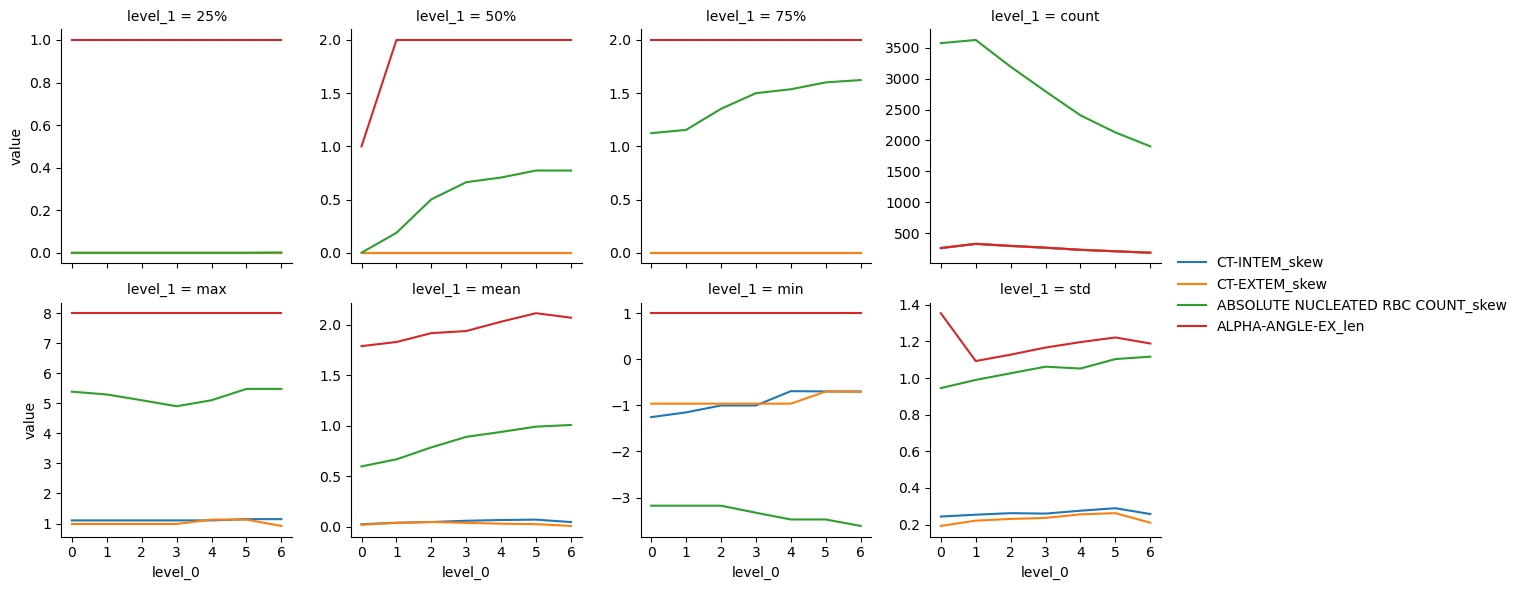

In [ ]:
# for feature in df.columns:
#     print(feature)
#     g = sns.FacetGrid(
#         melted[melted["Features"] == feature],
#         col="level_1", col_wrap=4, sharey=False
#     )
#     g.map(sns.lineplot, "level_0", "value")

g = sns.FacetGrid( melted, col="level_1", col_wrap=4, sharey=False)
g.map(sns.lineplot, "level_0", "value", hue=melted["Features"])
g.add_legend()

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

file = join(each_window_results[0].info.artifact_uri, "img_artifacts", "xgb_test__feature_importance.png")
img = mpimg.imread(file)
plt.imshow(img)
plt.show()

/tmp/ipykernel_25992/525006320.py:5: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  img = mpimg.imread(file)


URLError: <urlopen error [Errno 2] No such file or directory: '/home/davina/Private/repos/CRRT/mlruns/1/c21d88cb96304826884e8906f2cefe8a/artifacts/img_artifacts/xgb_test__feature_importance.png'>

In [ ]:
import numpy as np
smallest_dataset = np.argmin(np.array(shapes)[:,0])
reference_ids = predict_probas[smallest_dataset].index

metrics = {}
for label, predict_proba, slide in zip(labels, predict_probas, slides):
    label_idxs = label.index.intersection(reference_ids)
    predict_proba_idxs = predict_proba.index.intersection(reference_ids)
    metrics[slide] = {
        metric_name: metric_fn(label[label_idxs], predict_proba[predict_proba_idxs], 0.5)
        for metric_name, metric_fn in METRIC_MAP.items()
    }
equal_sized_df = pd.DataFrame.from_dict(metrics, orient="index").rename_axis(index="Slide").sort_index(axis=0)
equal_sized_df

,auroc,ap,brier,accuracy,f1,recall,specificity,precision,TN,FN,TP,FP
Slide,,,,,,,,,,,,
0,0.439216,0.509219,0.332247,0.46875,0.514286,0.529412,0.400000,0.500000,6,8,9,9
1,0.439216,0.545535,0.352427,0.46875,0.540541,0.588235,0.333333,0.500000,5,7,10,10
2,0.501961,0.607398,0.329569,0.50000,0.578947,0.647059,0.333333,0.523810,5,6,11,10
3,0.572549,0.601873,0.303588,0.50000,0.529412,0.529412,0.466667,0.529412,7,8,9,8
4,0.564706,0.556221,0.296960,0.56250,0.588235,0.588235,0.533333,0.588235,8,7,10,7
5,0.549020,0.539734,0.302747,0.65625,0.685714,0.705882,0.600000,0.666667,9,5,12,6
6,0.603922,0.576211,0.293186,0.59375,0.648649,0.705882,0.466667,0.600000,7,5,12,8


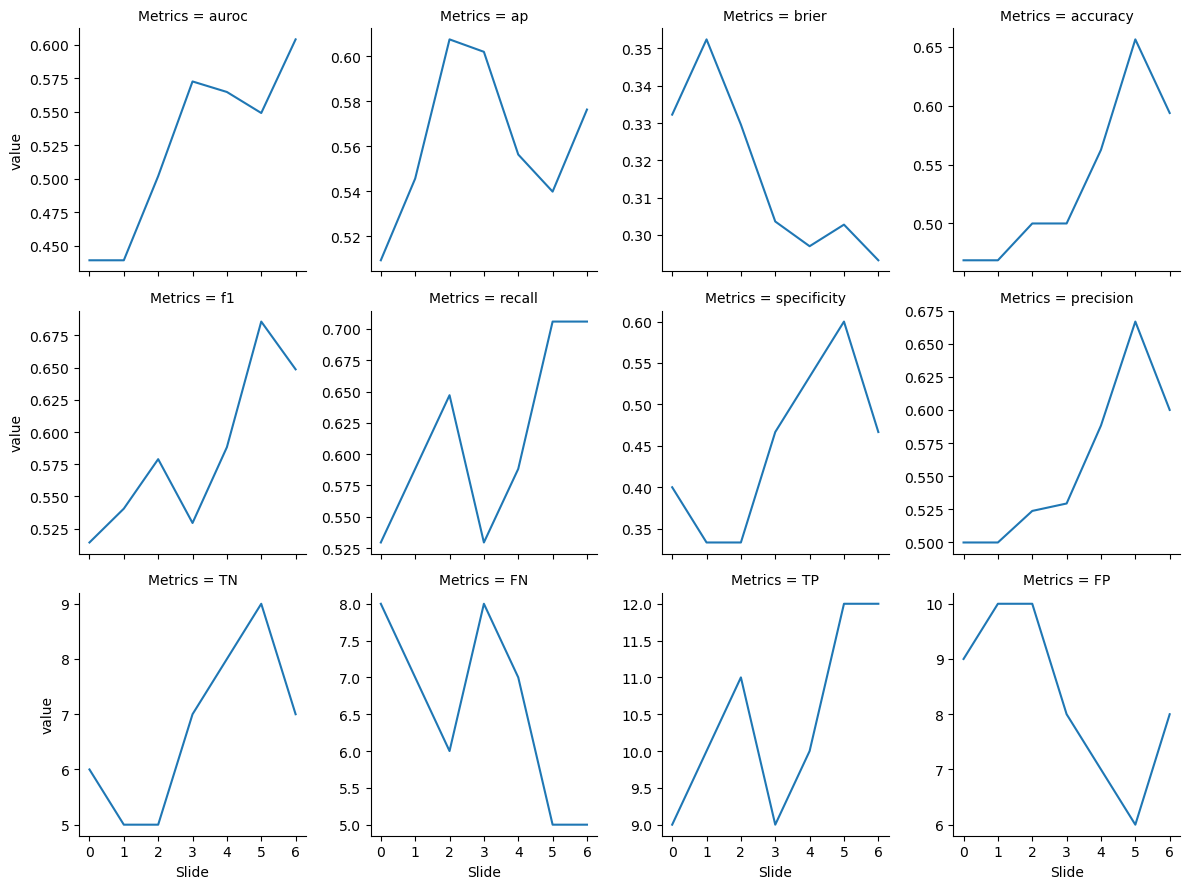

In [ ]:
# g = sns.lineplot(data=metrics_over_windows)
# g = sns.relplot(data=metrics_over_windows, kind="line")
# g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
# plt.show()
g = sns.FacetGrid(
    equal_sized_df.melt(ignore_index=False,var_name="Metrics").reset_index(),
    col="Metrics", col_wrap=4, sharey=False
)
g.map(sns.lineplot, "Slide", "value")

# No filter, visualize metrics across windows

In [ ]:
metrics_over_windows = pd.DataFrame(
    [run.data.metrics for run in each_window_results],
    index=[run.data.tags["slide_window_by"] for run in each_window_results]
).rename_axis(index="Slide").sort_index(axis=0)
# metrics_over_windows.columns = pd.MultiIndex.from_product([["Metrics"], metrics_over_windows.columns])
metrics_over_windows

,lgb_test_no_heart_liver_infection__FP,lgb_test_no_heart_liver_infection__auroc,lgb_test__ap,lgb_test__TP,lgb_test_heart__ap,lgb_test_heart__brier,lgb_test_heart__TP,lgb_test_infection__FN,lgb_test_no_heart_liver_infection__precision,lgb_test_liver__recall,...,lgb_test_liver__TP,lgb_test_liver__ap,lgb_test_liver__TN,lgb_test__FP,lgb_test_liver__FN,lgb_test_liver__FP,lgb_test_infection__precision,lgb_test_no_heart_liver_infection__brier,lgb_test_infection__ap,lgb_test_heart__TN
Slide,,,,,,,,,,,,,,,,,,,,,
0,22.0,0.850242,0.896184,177.0,0.918476,0.133317,72.0,10.0,0.822581,0.835294,...,71.0,0.909168,60.0,45.0,14.0,22.0,0.750000,0.157130,0.903301,63.0
1,10.0,0.915007,0.946706,173.0,0.947161,0.113251,89.0,11.0,0.891304,0.854167,...,82.0,0.939369,63.0,27.0,14.0,17.0,0.828947,0.117790,0.935762,63.0
2,12.0,0.896051,0.948657,142.0,0.956524,0.103987,66.0,9.0,0.860465,0.864865,...,64.0,0.952648,43.0,21.0,10.0,9.0,0.872727,0.129076,0.950483,44.0
3,5.0,0.892308,0.961562,102.0,0.989085,0.062662,50.0,1.0,0.912281,0.978723,...,46.0,0.987179,24.0,9.0,1.0,4.0,0.900000,0.132276,0.989247,25.0
4,5.0,0.877143,0.947751,56.0,0.983855,0.075984,27.0,1.0,0.852941,0.884615,...,23.0,0.978945,15.0,6.0,3.0,1.0,0.952381,0.145731,0.987150,14.0
5,3.0,0.891775,0.938089,28.0,0.972222,0.096449,11.0,0.0,0.850000,0.900000,...,9.0,0.961429,6.0,4.0,1.0,1.0,0.875000,0.129171,1.000000,7.0
6,3.0,0.909091,0.952742,16.0,1.000000,0.073328,3.0,0.0,0.812500,1.000000,...,2.0,1.000000,3.0,4.0,0.0,1.0,0.750000,0.112749,1.000000,3.0


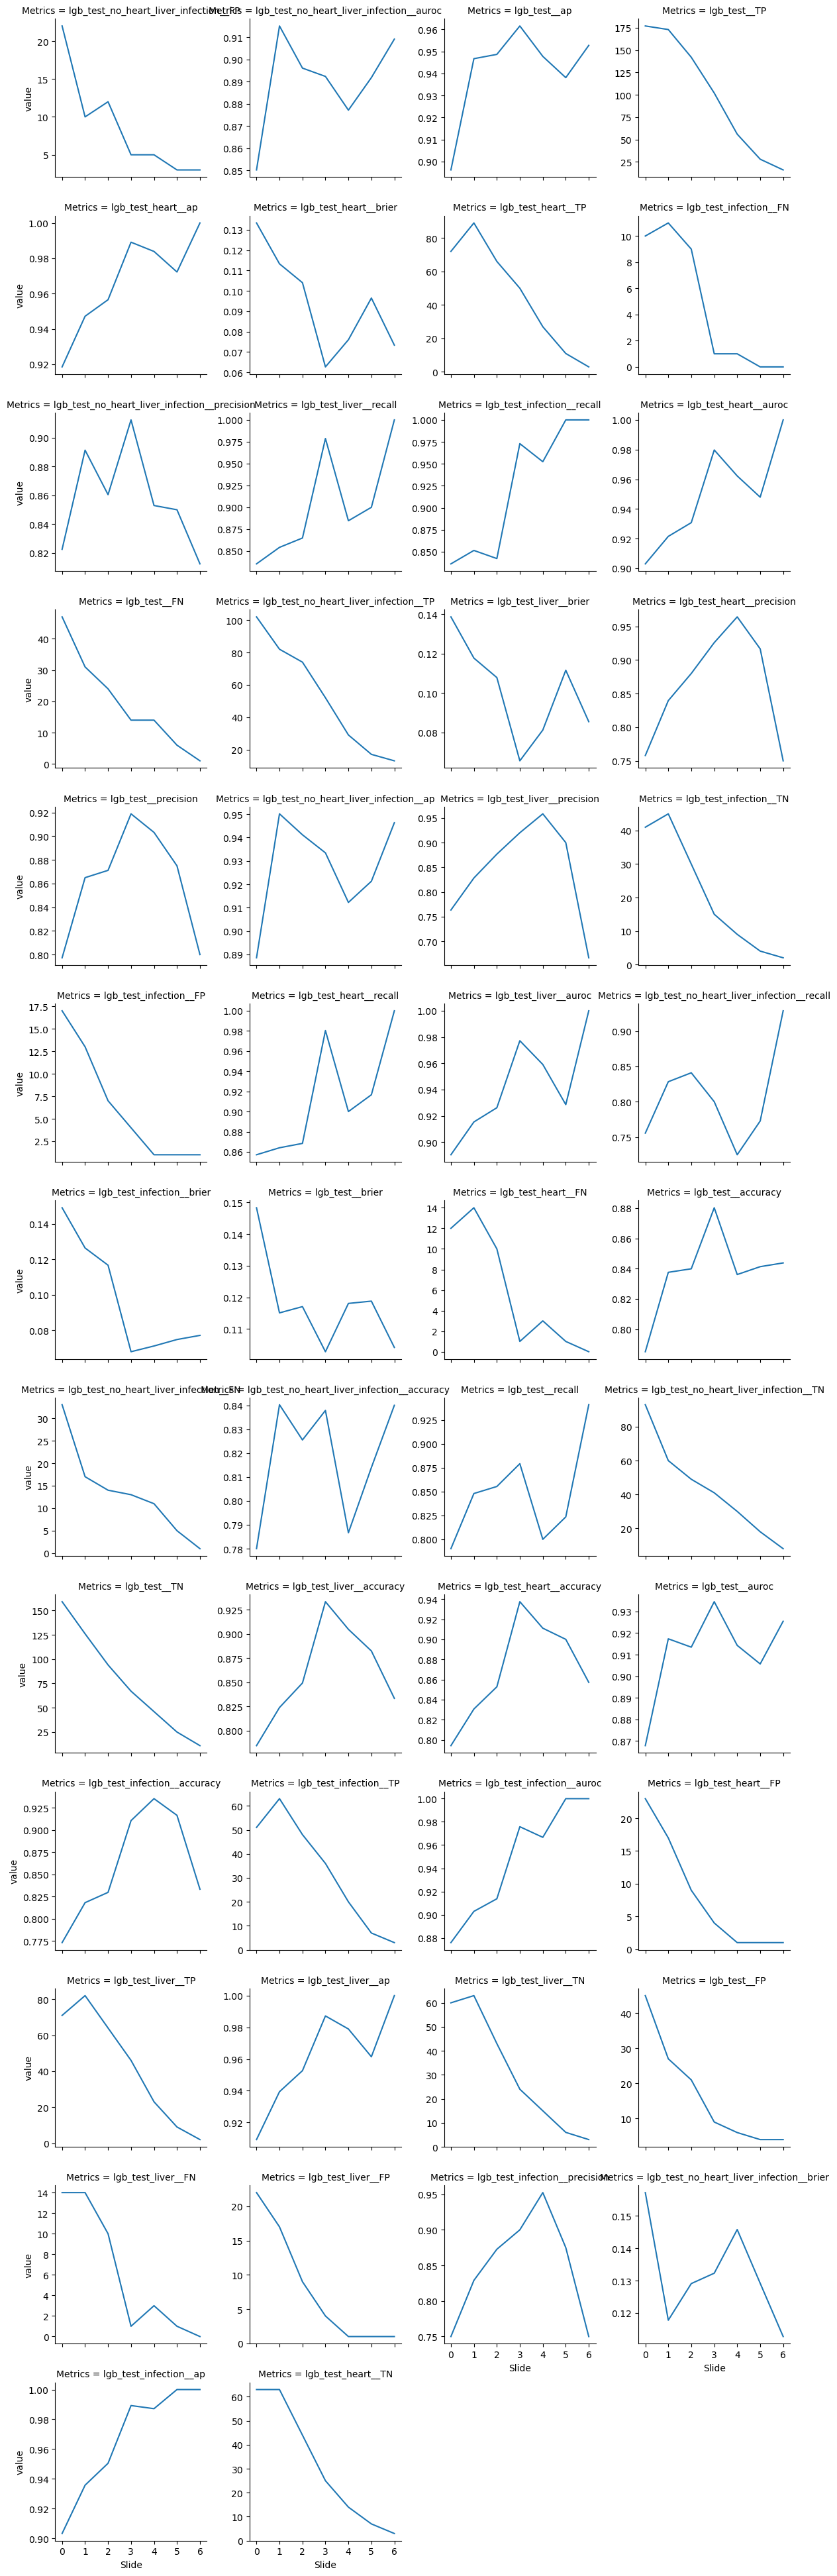

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# g = sns.lineplot(data=metrics_over_windows)
# g = sns.relplot(data=metrics_over_windows, kind="line")
# g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
# plt.show()
g = sns.FacetGrid(
    metrics_over_windows.melt(ignore_index=False,var_name="Metrics").reset_index(),
    col="Metrics", col_wrap=4, sharey=False
)
g.map(sns.lineplot, "Slide", "value")

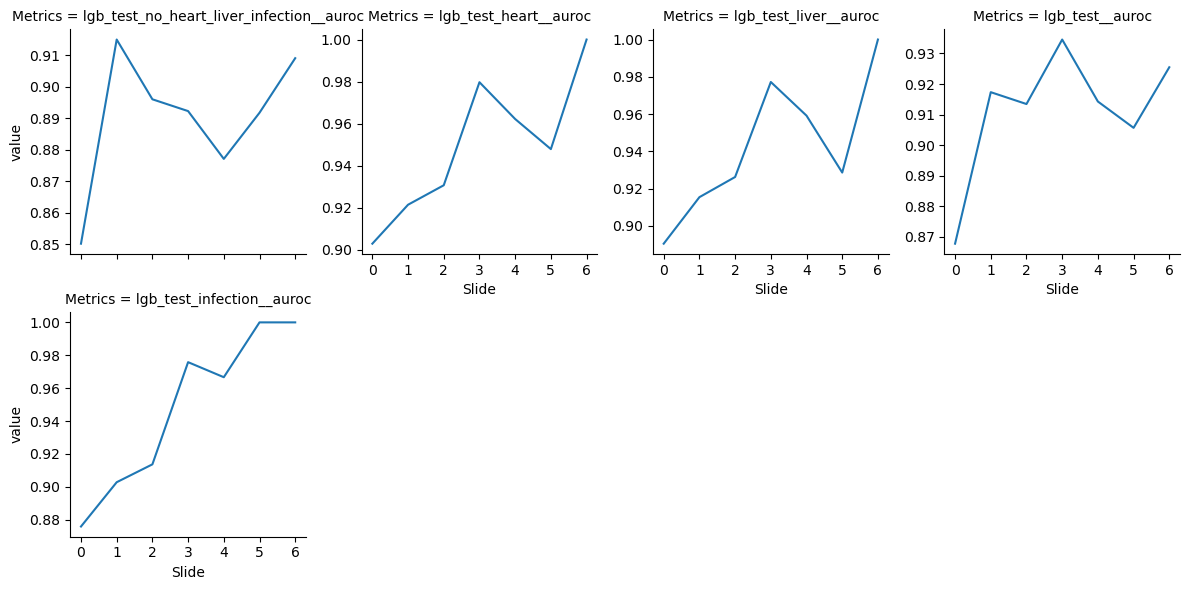

In [ ]:
# AUROC ONLY
auroc_mask = metrics_over_windows.columns.str.contains("auroc")
auroc_cols = metrics_over_windows.columns[auroc_mask]
g = sns.FacetGrid(
    metrics_over_windows[auroc_cols].melt(ignore_index=False,var_name="Metrics").reset_index(),
    col="Metrics", col_wrap=4, sharey=False
)
g.map(sns.lineplot, "Slide", "value")

In [ ]:
# cleanup
# for run in runs:
#     client.delete_run(run.info.run_id)